In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Loading data
***Dataset:*** [Facial Keypoints Detection](https://www.kaggle.com/c/facial-keypoints-detection/data)

In [2]:
training = pd.read_csv(os.path.join('data', 'training', 'training.csv'))
test = pd.read_csv(os.path.join('data', 'test', 'test.csv'))

In [3]:
test.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


### Process training images
Image data is provided as a str of gray scale intensities.
- Image size is 96x96

In [4]:
x_train = training['Image']

In [5]:
x_train.head()

0    238 236 237 238 240 240 239 241 241 243 240 23...
1    219 215 204 196 204 211 212 200 180 168 178 19...
2    144 142 159 180 188 188 184 180 167 132 84 59 ...
3    193 192 193 194 194 194 193 192 168 111 50 12 ...
4    147 148 160 196 215 214 216 217 219 220 206 18...
Name: Image, dtype: object

In [6]:
def str2img(strarr):
    img = strarr.split(' ')
    img = ['0' if x == '' else x for x in img]
    return img

def process_X(X):
    imag = [str2img(x) for x in X]
    image_list = np.array(imag,dtype = 'float')
    return image_list.reshape(-1,96,96,1)

In [7]:
x_train = process_X(x_train)

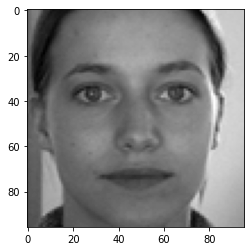

In [8]:
plt.imshow(x_train[69].reshape(96,96),cmap='gray')
plt.show()

### Process labels
- Fill missing values with forward fill, which uses last valid value.

In [9]:
y_train = training.loc[:, training.columns != 'Image']
y_train.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [10]:
sum(y_train.isnull().any())

28

In [11]:
y_train.fillna(method = 'ffill',inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [12]:
sum(y_train.isnull().any())

0

In [13]:
y = y_train.copy()

y_train = []
for i in range(len(y)):
    y_train.append(y.iloc[i,:])

y_train = np.array(y, dtype='float')

In [14]:
print(f'x_train.shape = {x_train.shape}')
print(f'y_train.shape = {y_train.shape}')

x_train.shape = (7049, 96, 96, 1)
y_train.shape = (7049, 30)


# Model

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, MaxPool2D, GlobalMaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [16]:
num_keypoints = 15

## Baseline model

In [17]:
model_baseline = tf.keras.models.Sequential([
    Conv2D(96, kernel_size=(7,7), strides=(3,3), padding='valid', input_shape=(96,96,1)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((3,3), strides=(2,2)),
    
    Conv2D(192, kernel_size=(5,5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(384, kernel_size=(3,3), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    
    Flatten(),
    Dense(num_keypoints * 2)
])

In [18]:
opt = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.MeanSquaredError()
model_baseline.compile(optimizer=opt, loss=loss_fn, metrics=['mae'])

In [19]:
model_baseline.fit(x_train, y_train, epochs=50, batch_size=256, validation_split=0.2)

Epoch 1/50
23/23 [==============================] - 1s 59ms/step - loss: 302.0359 - mae: 11.9030 - val_loss: 71860.4219 - val_mae: 228.6062
Epoch 2/50
23/23 [==============================] - 1s 50ms/step - loss: 21.2218 - mae: 3.4585 - val_loss: 8874.9473 - val_mae: 79.8644
Epoch 3/50
23/23 [==============================] - 1s 50ms/step - loss: 13.7580 - mae: 2.6541 - val_loss: 1454.2396 - val_mae: 29.5174
Epoch 4/50
23/23 [==============================] - 1s 50ms/step - loss: 10.3760 - mae: 2.2001 - val_loss: 367.9857 - val_mae: 14.2526
Epoch 5/50
23/23 [==============================] - 1s 50ms/step - loss: 9.7511 - mae: 2.0958 - val_loss: 135.4442 - val_mae: 8.7179
Epoch 6/50
23/23 [==============================] - 1s 50ms/step - loss: 10.3683 - mae: 2.2174 - val_loss: 93.8300 - val_mae: 7.7849
Epoch 7/50
23/23 [==============================] - 1s 50ms/step - loss: 10.3613 - mae: 2.2272 - val_loss: 75.2255 - val_mae: 6.5237
Epoch 8/50
23/23 [==============================] - 1s

## Resnet model

Resnet code from Coursera Deep learning specialization.

**N.B.**: 
- pre-trained models are provided.
- Image is not representative of the actual network architecture.
<img src="resnet50_blocks.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 5** </u><font color='purple'>  : **ResNet-50 model** </center></caption>

In [20]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1,1), padding='valid', name=conv_name_base+'2c')(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding='same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [21]:
def ResNet50(input_shape = (96, 96, 1), landmark_points = 30):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(96, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [96, 96, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [96, 96, 256], stage=2, block='b')
    X = identity_block(X, 3, [96, 96, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [192, 192, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [192, 192, 512], stage=3, block='b')
    X = identity_block(X, 3, [192, 192, 512], stage=3, block='c')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [384, 384, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [384, 384, 1024], stage=4, block='b')
    X = identity_block(X, 3, [384, 384, 1024], stage=4, block='c')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [768, 768, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [768, 768, 2048], stage=5, block='b')
    
    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
#     X = AveragePooling2D(pool_size = (2,2), name = 'avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(landmark_points, name='fc' + str(landmark_points))(X)

    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [22]:
model = ResNet50(input_shape = (96, 96, 1), landmark_points = num_keypoints * 2)

In [23]:
model.compile(optimizer=opt, loss=loss_fn, metrics=['mae'])

In [24]:
# model.fit(x_train, y_train, epochs=2000, batch_size=256, validation_split=0.2)

## Save models

In [25]:
model_baseline.save('models/model_baseline.h5')
model.save('models/model.h5')

# Load models

In [26]:
%time model_baseline = tf.keras.models.load_model('models/model_baseline.h5')

CPU times: user 140 ms, sys: 12.9 ms, total: 153 ms
Wall time: 146 ms


In [27]:
%time model = tf.keras.models.load_model('models/model.h5')

CPU times: user 1.04 s, sys: 101 ms, total: 1.14 s
Wall time: 1.1 s


# Testset
Test the model with unseen data from the test set, plot all faces + landmarks.

In [28]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(x, cmap='gray')
    axis.scatter(y[0::2], y[1::2], marker='o', s=10)

def plot_16_test(x_test, preds):
    fig = plt.figure(figsize=(15, 10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(16):
        axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        plot_sample(x_test[i], preds[i], axis)

    plt.show()

In [29]:
x_test = process_X(test['Image']) 

In [30]:
preds_baseline = model_baseline.predict(x_test)
preds = model.predict(x_test)

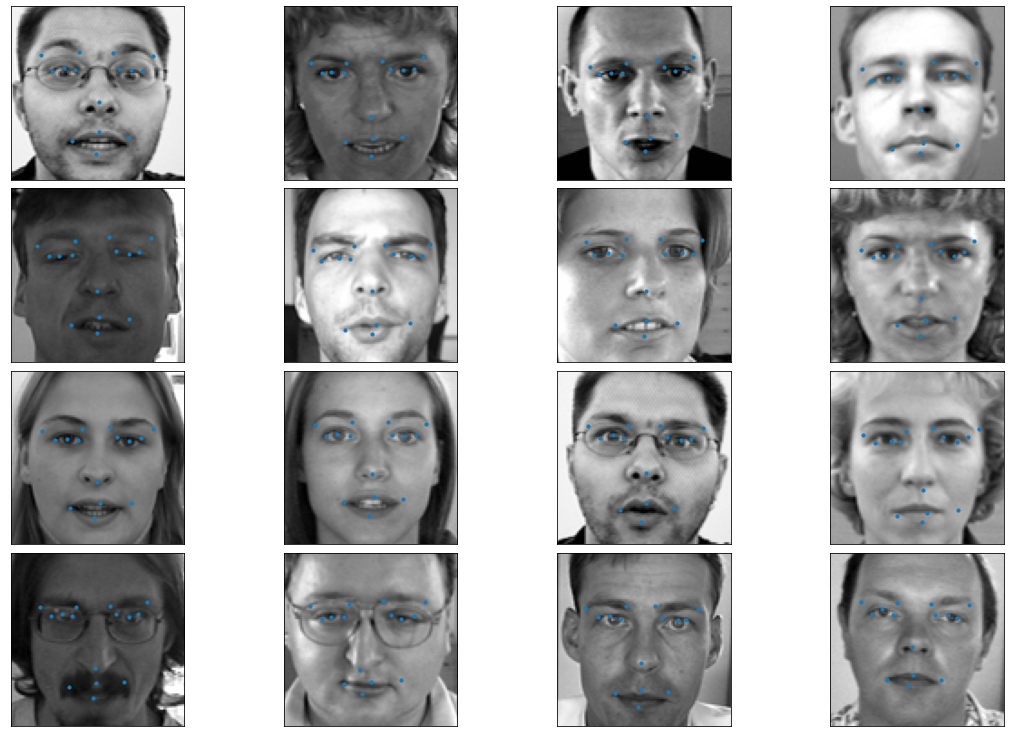

In [31]:
plot_16_test(x_test, preds_baseline)

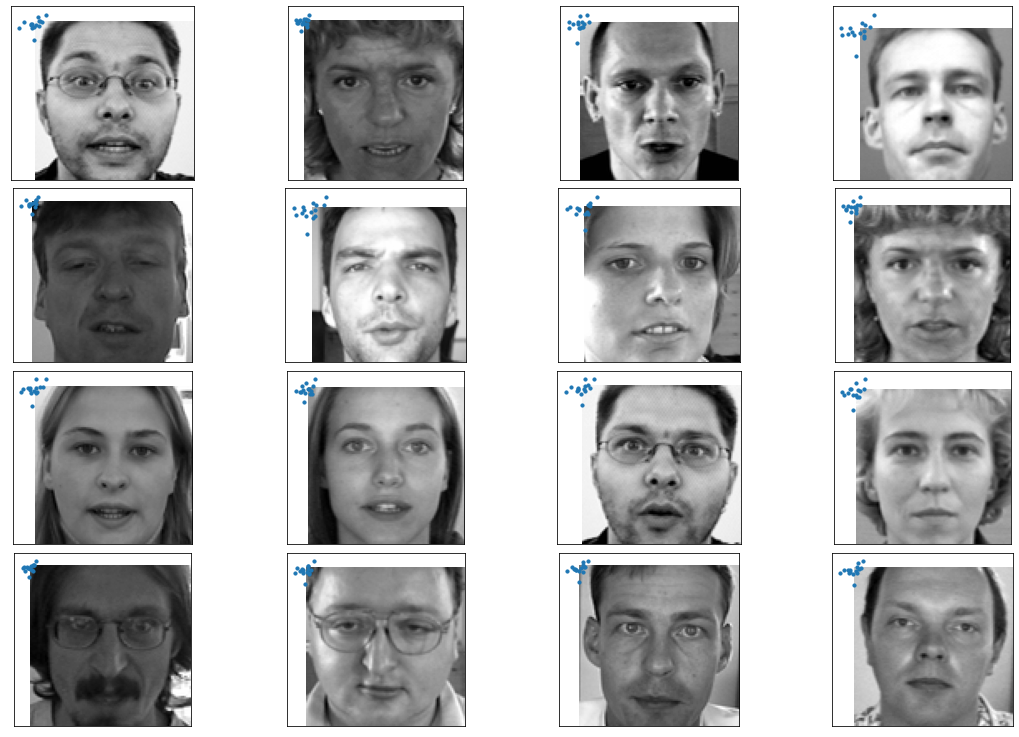

In [32]:
plot_16_test(x_test, preds)

# Submission

In [33]:
sample_sub = pd.read_csv('data/SampleSubmission.csv')
sample_sub.head()

,RowId,Location
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [34]:
header = list(training.drop('Image', axis=1).columns)
header

['left_eye_center_x',
 'left_eye_center_y',
 'right_eye_center_x',
 'right_eye_center_y',
 'left_eye_inner_corner_x',
 'left_eye_inner_corner_y',
 'left_eye_outer_corner_x',
 'left_eye_outer_corner_y',
 'right_eye_inner_corner_x',
 'right_eye_inner_corner_y',
 'right_eye_outer_corner_x',
 'right_eye_outer_corner_y',
 'left_eyebrow_inner_end_x',
 'left_eyebrow_inner_end_y',
 'left_eyebrow_outer_end_x',
 'left_eyebrow_outer_end_y',
 'right_eyebrow_inner_end_x',
 'right_eyebrow_inner_end_y',
 'right_eyebrow_outer_end_x',
 'right_eyebrow_outer_end_y',
 'nose_tip_x',
 'nose_tip_y',
 'mouth_left_corner_x',
 'mouth_left_corner_y',
 'mouth_right_corner_x',
 'mouth_right_corner_y',
 'mouth_center_top_lip_x',
 'mouth_center_top_lip_y',
 'mouth_center_bottom_lip_x',
 'mouth_center_bottom_lip_y']

In [35]:
test_predicts = pd.DataFrame(preds_baseline, columns = header)
test_predicts

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.009064,34.477783,29.106911,33.443184,59.492477,34.398865,72.390854,35.557747,34.958759,35.023071,...,48.614376,52.232677,64.580360,72.401199,33.341171,73.846779,48.565975,69.153664,46.539501,81.429855
1,65.446236,34.785736,25.530485,35.749683,57.913338,34.394005,71.196999,34.185524,32.751095,36.139469,...,47.877472,60.935844,64.837471,71.658943,33.274887,74.744484,48.985107,72.429466,47.635357,82.152039
2,64.903725,35.507992,29.282650,36.674503,58.437889,33.332390,70.736420,33.574627,35.241524,36.538673,...,49.088150,60.246716,64.996994,70.756165,36.924259,74.423477,50.830639,72.163498,48.104630,79.599358
3,67.967873,37.305775,31.497215,39.229073,60.154194,37.466103,75.442825,38.222351,36.866184,39.584976,...,49.363857,56.850323,69.592979,76.239906,33.342201,78.731987,50.432922,75.132011,49.228481,80.841881
4,64.989639,35.698185,26.359461,36.595985,57.711498,34.062157,70.650803,34.641880,33.182457,36.192001,...,47.100143,56.025116,65.188263,71.820023,32.826157,75.054260,48.099789,70.402466,47.004108,79.511269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,65.996284,35.519955,30.312418,32.657658,58.628132,33.663567,73.378075,34.271442,36.465057,36.616341,...,48.220634,62.641129,68.653587,70.016060,32.767563,73.376457,49.536362,74.790421,45.802246,72.750580
1779,68.067329,36.678505,30.378790,43.429344,61.233009,34.860828,76.968903,34.333839,37.513783,39.823170,...,51.998489,67.823868,75.766640,72.411392,35.799412,79.810478,53.650970,80.538940,53.966167,77.435814
1780,71.531677,42.825047,33.245861,38.243237,62.103142,35.793789,77.983017,35.924820,38.281315,40.198723,...,48.611614,70.850052,75.854012,76.089890,35.521194,81.625923,53.962151,81.823097,46.831341,81.851944
1781,67.244972,36.157478,29.955267,38.261986,59.149010,35.402542,74.076439,35.398098,35.910984,38.179039,...,44.584461,62.904205,69.231705,72.806877,33.802952,76.730965,49.844719,76.080872,45.847626,77.155693


In [36]:
IdLookupTable = pd.read_csv(os.path.join('data', 'IdLookupTable.csv'))
for i in range(IdLookupTable.shape[0]):
    IdLookupTable.Location[i] = test_predicts.loc[IdLookupTable.ImageId[i]-1][IdLookupTable.FeatureName[i]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
sample_sub.Location = IdLookupTable.Location.astype(int)
my_submission = sample_sub
my_submission

,RowId,Location
0,1,66
1,2,34
2,3,29
3,4,33
4,5,59
...,...,...
27119,27120,36
27120,27121,47
27121,27122,63
27122,27123,46


In [38]:
my_submission.to_csv('submission.csv', index=False)

# Test with custom image
Test your own face!
- Images are cropped with 1:1 ration in the center and converted to greyscale.

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps

def crop_image(image):
    width, height = image.size
    if width == height:
        return image
    offset  = int(abs(height-width)/2)
    if width>height:
        image = image.crop([offset,0,width-offset,height])
    else:
        image = image.crop([0,offset,width,height-offset])
    return image

Image size = (96, 96)


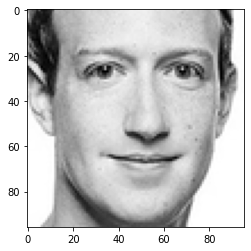

In [40]:
image_path = 'face.jpg'

img = Image.open(image_path).convert('L')
img = crop_image(img)
img = img.resize((96,96), Image.ANTIALIAS)
imgplot = plt.imshow(img, cmap='gray')
print(f'Image size = {img.size}')

In [41]:
test_img = np.asarray(img).reshape(1,96,96,1)
test_img.shape

(1, 96, 96, 1)

In [42]:
x_train[69].shape

(96, 96, 1)

### Detection with baseline model

CPU times: user 94.9 ms, sys: 0 ns, total: 94.9 ms
Wall time: 93.1 ms


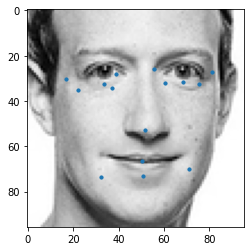

In [43]:
%time pred_y = model_baseline.predict(test_img)
plot_sample(test_img[0], pred_y[0], plt)
plt.show()

### Detection with Resnet-50 model

CPU times: user 605 ms, sys: 0 ns, total: 605 ms
Wall time: 603 ms


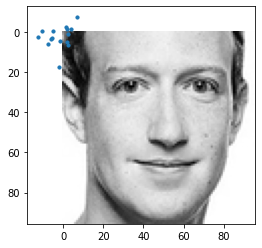

In [44]:
%time pred_y = model.predict(test_img)
plot_sample(test_img[0], pred_y[0], plt)
plt.show()

The model does not seem to detect lizard faces...